In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp given_models

# given_models
> i.e. routines for setting up and using pretrained AutoEncoder models

Currently included:
- Baselines: Spectrogram (i.e. complex STFT), MagSpectrogram, MelSpectrogram
- Diffusion models: DVAE (unmasked)

To be added: 
- Diffusion models: masked DVAE , archinet's
- Others groups': JukeBox (as "IceBox"), RAVE,...? 

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from __future__ import annotations  # for type hints LAION code samples
import os
import numpy as np 
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms as T
import pytorch_lightning as pl
import math
from tqdm import trange

# audio-diffusion imports
from copy import deepcopy
import pytorch_lightning as pl
from diffusion.pqmf import CachedPQMF as PQMF
from encoders.encoders import AttnResEncoder1D
from autoencoders.soundstream import SoundStreamXLEncoder
from dvae.residual_memcodes import ResidualMemcodes
from decoders.diffusion_decoder import DiffusionAttnUnet1D
from diffusion.model import ema_update
from einops import rearrange

from audio_algebra.DiffusionDVAE import DiffusionDVAE, sample

In [ ]:
# imports not needed for library but used in documentation/tests/demo
import matplotlib.pyplot as plt
from aeiou.viz import playable_spectrogram, audio_spectrogram_image, tokens_spectrogram_image
from aeiou.core import load_audio
from aeiou.datasets import Stereo
from aeiou.hpc import freeze
from IPython.display import display, HTML  # just for displaying inside notebooks

# Wrapper API: "GivenModelClass"
We're going to make a bunch of wrappers that are PyTorch modules. The API for the wrappers will be as follows: 
- `.encode()`: encodes the (batch of) (raw) audio waveform(s) into encodings aka "representations" `reps`, where `reps` should have shape `([b,]c,d,n)` where `b` is an optional batch dimension (matching that of the waveform input), `c` may or may not correspond to actual audio channels (e.g. for DVAE, c=1 even for stereo). `d` and `n` are typically the "dimensions" of the embeddings and the time step/frame, respectively, but some models may not respect this.
- `.decode()`: decodes the (batch of) encodings/representations from the encoder into "reconstruction" waveforms `recons`
- `.forward()`: calls *both* `encode()` and `decode()` in succesion, returns tuple `(reps, recons)`
- `.setup()`: an optional routine that will load checkpoints & do other 'init' stuff (but not done automatically in `init`)
- `self.ckpt_info{}`: dict that includes URL and approved hash value for pretrained model checkpoint. Default is no info

In [ ]:
#|export
class GivenModelClass(nn.Module):
    "This provides an (optional) 'shorthand' structure for (some) given_models"
    def __init__(self,
        zero_pad=True,
        make_sizes_match=True,
        device='cuda',
        ckpt_info={'ckpt_path':'', 'ckpt_url':'','ckpt_hash':'', 'gdrive_path':''}, # info on pretrained checkpoints
        **kwargs,  # these are so that some models can ignore kwargs needed by others
        ):
        super().__init__()
        self.make_sizes_match, self.orig_shape, self.zero_pad, self.device, self.ckpt_info  = make_sizes_match, None, zero_pad, device, ckpt_info
        self.name = self.__class__.__name__  # just a shorthand
    def setup(self):
        "Setup can include things such as downloading checkpoints"
        pass  
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        return None
    def decode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        return None    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        "Calls .encode() and .decode() in succession, returns both results as tuple"
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)
    
    def get_checkpoint(self):
        "This just ensures that the checkpoint file (if one is available) will be present on the local disk at self.ckpt_info['ckpt_path']"
        if self.ckpt_info=={} or all(x=='' for x in self.ckpt_info.values()): 
            print("No checkpoint info available.")
            return
        #@title Mount or Download Checkpoint
        on_colab = os.path.exists('/content')
        if on_colab:  # get it on colab
            from google.colab import drive
            drive.mount('/content/drive/') 
            ckpt_file = '/content/drive/'+self.ckpt_info['gdrive_path']
            while not os.path.exists(ckpt_file):
                print(f"\nPROBLEM: Expected to find the checkpoint file at {ckpt_file} but it's not there.\nWhere is it? (Go to the File system in the left sidebar and find it)")
                ckpt_file = input('Enter location of checkpoint file: ')
        else:
            ckpt_file = self.ckpt_info['ckpt_path'] #'checkpoint.ckpt'
            if not os.path.exists(ckpt_file):
                url = self.ckpt_info['ckpt_url']
                # downloading large files from GDrive requires special treatment to bypass the dialog button it wants to throw up
                id = url.split('/')[-2]
                #cmd = f'wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \'https://docs.google.com/uc?export=download&id={id}\' -O- | sed -rn \'s/.*confirm=([0-9A-Za-z_]+).*/\1\\n/p\')&id={id}" -O {ckpt_file} && rm -rf /tmp/cookies.txt'
                cmd = f"gdown -O {ckpt_file} {id}"
                subprocess.run(cmd, shell=True, check=True) 
                #!gdown -O {ckpt_file} {id}

                print(f"\nSecurity: checking hash on downloaded checkpoint file...")
                new_hash = subprocess.run(['shasum', '-a','256',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8').split(' ')[0]
                #new_hash = subprocess.run(['md5sum',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8')
                assert new_hash == self.ckpt_info['ckpt_hash'], "Hashes don't match. STOP THE NOTEBOOK. DO NOT EXECUTE."
                print("Checkpoint hash checks out.")
            else:
                print("Checkpoint found!")
    
    def match_sizes(self, recon) -> torch.Tensor:
        "match recon size to original waveform size, if possible"
        if self.make_sizes_match and (self.orig_shape is not None) and (recon.shape != self.orig_shape):
            if recon.shape[-1] > self.orig_shape[-1]:  # recon is longer
                recon = recon[:,:self.orig_shape[-1]]
            else: # recon is shorter
                recon2 = torch.zeros(self.orig_shape)  # slow but what are you gonna do
                recon2[:,:self.orig_shape[-1]] = recon
                recon = recon2 
            assert recon.shape == self.orig_shape, f"Did not succeed in making size match. recon.shape ({recon.shape}) != self.orig_shape ({self.orig_shape})"
        return recon       
    
    #--- couple extra routines probably only useful for fourier-based AE's but no harm done including them here
    def next_power_of_2(self, x:int) -> int:  
        return 1 if x == 0 else 2**(x - 1).bit_length()

    def zero_pad_po2(self, x:int) -> int:
        "useful for padding to nearest power of 2, useful for fourier-based transforms"
        new_shape = list(x.shape)
        new_shape[-1] = self.next_power_of_2(new_shape[-1])
        new_x = torch.zeros(new_shape).to(x.device)
        new_x[:,:x.shape[-1]] = x
        return new_x

# Baselines

In [ ]:
#|export
class SpectrogramAE(GivenModelClass):
    "Raw (complex) spectrogram. See torchaudio.Spectrogram & InverseSpectrogram for kwarg info"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=None, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs).to(self.device)
        self.decoder = T.InverseSpectrogram(    n_fft=n_fft, hop_length=hop_length, center=center, **kwargs).to(self.device)
        
    def encode(self, waveform: torch.Tensor,**kwargs) -> torch.Tensor:
        "Note that this produces complex numbers by default"
        self.orig_shape = waveform.shape # can use this for matching output size later
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        "this decoder offers perfect reconstruction"
        return self.match_sizes( self.decoder(reps) )

Let's test that...

Resampling ../aeiou/examples/example.wav from 44100 Hz to 48000 Hz
waveform.shape = torch.Size([2, 55728])


/admin/home-shawley/envs/aa/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


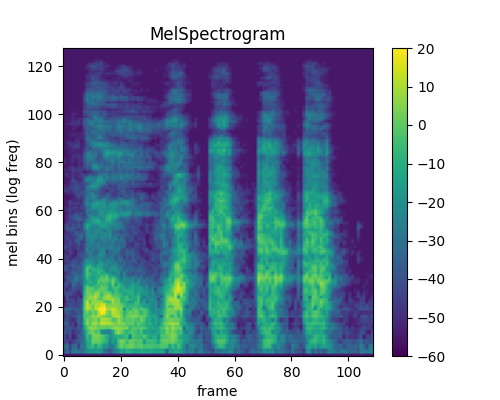

<matplotlib.legend.Legend>

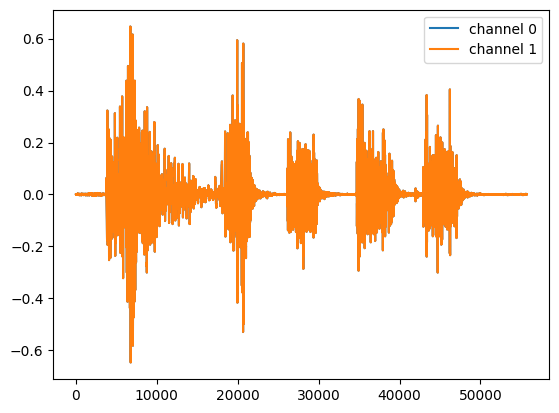

In [ ]:
#| eval: false
data_path = '../aeiou/examples/'
waveform = load_audio(data_path+'example.wav')
stereo_op = Stereo()
waveform = stereo_op(waveform)
print("waveform.shape =",waveform.shape)
#playable_spectrogram(waveform, output_type='live')
spec_graph = audio_spectrogram_image(waveform.cpu(), justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
for c in range(waveform.shape[0]):
    plt.plot(waveform[c].cpu().numpy(), label=f'channel {c}')
plt.legend()

Now show that "`recon`" results of the inverse transform are very close to the original waveform:

spec.shape, recon.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])
spec.dtype =  torch.complex64


<matplotlib.legend.Legend>

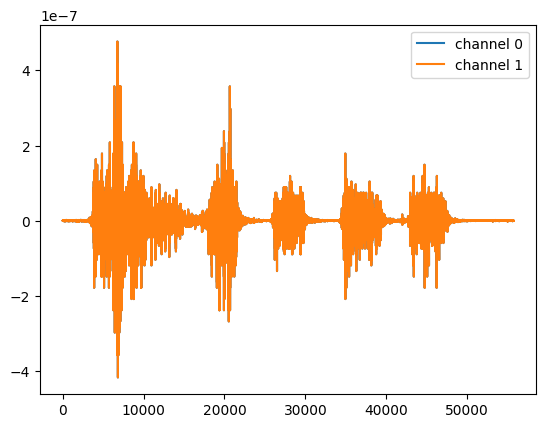

In [ ]:
#| eval: false
device='cuda'
given_model = SpectrogramAE().to(device)
spec, recon = given_model.forward(waveform.to(device))
print("spec.shape, recon.shape = ",spec.shape, recon.shape)
print("spec.dtype = ",spec.dtype)
diff = recon.cpu()-waveform

#playable_spectrogram(diff, output_type='live') #plot/play the difference
#spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
#display(spec_graph)
for c in range(waveform.shape[0]):
    plt.plot(diff[c].cpu().numpy(), label=f'channel {c}')
plt.legend()

In [ ]:
#|export
class MagSpectrogramAE(GivenModelClass):
    "Magnitude spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        n_fft=1024,   
        hop_length=256,
        center=True,
        device='cuda',
        **kwargs,
    ):
        super().__init__()
        self.encoder = T.Spectrogram(power=2, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs).to(device)
        self.decoder = T.GriffinLim(          n_fft=n_fft, hop_length=hop_length, **kwargs).to(device)
        self.device = device
        
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, reps: torch.Tensor, **kwargs) -> torch.Tensor:
        "Note that GriffinLim decoding *guesses* at the phase"
        return self.match_sizes( self.decoder(reps) )

magspec.shape, recon2.shape =  torch.Size([2, 513, 257]) torch.Size([2, 55728])
magspec.dtype =  torch.float32


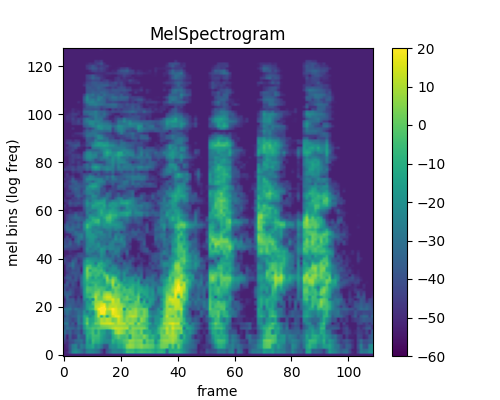

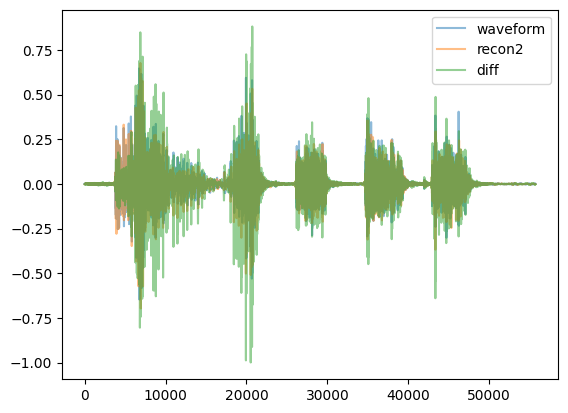

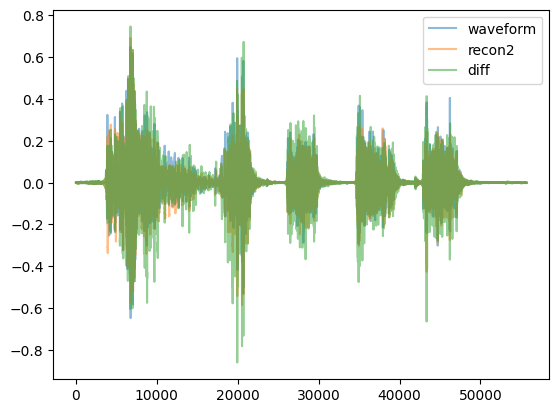

In [ ]:
#| eval: false

# test that
magspecfunc = MagSpectrogramAE(device=device)
magspec, recon2 = magspecfunc.forward(waveform.to(device))
print("magspec.shape, recon2.shape = ",magspec.shape, recon2.shape )
print("magspec.dtype = ",magspec.dtype)
recon2 = recon2.to('cpu')
diff = recon2-waveform

#playable_spectrogram(diff, specs="waveform", output_type='live') #plot/play the difference
spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
c = 0 # show left channel
for thing, name in zip([waveform, recon2, diff], ['waveform', 'recon2', 'diff']):
    plt.plot(thing[c].cpu().numpy(), alpha=0.5, label=name)
plt.legend()
plt.show()
c = 1  # show right channel
for thing, name in zip([waveform, recon2, diff], ['waveform', 'recon2', 'diff']):
    plt.plot(thing[c].cpu().numpy(), alpha=0.5, label=name)
plt.legend()
plt.show()

In [ ]:
#|export
class MelSpectrogramAE(GivenModelClass):
    "Mel spectrogram encoder, GriffinLim decoder"
    def __init__(self,
        sample_rate=48000,
        n_fft=1024,   
        hop_length=256,
        center=True,
        device='cuda',
        **kwargs, # these are mainly just so that we can ignore kwargs that other models need
    ):
        super().__init__()
        self.encoder = nn.Sequential( T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, center=center, **kwargs)).to(device)
        self.inv_melscale_t = T.InverseMelScale(n_stft=n_fft // 2 + 1).to(device) 
        self.decoder = T.GriffinLim(n_fft=n_fft, hop_length=hop_length, **kwargs).to(device)
        self.device = device
        
    def encode(self, waveform: torch.Tensor, **kwargs) -> torch.Tensor:
        self.orig_shape = waveform.shape
        return self.encoder(self.zero_pad_po2(waveform)) if self.zero_pad else self.encoder(waveform)

    def decode(self, melspec: torch.Tensor, **kwargs) -> torch.Tensor:
        spec = self.inv_melscale_t(melspec)
        return self.match_sizes( self.decoder(spec) )
    
    def forward(self, waveform: torch.Tensor)-> (torch.Tensor, torch.Tensor):
        "Calls .encode() and .decode() in succession, returns both results as tuple"
        reps = self.encode(waveform)
        recons = self.decode(reps)
        return (reps, recons)

melspec.device, melspec.shape, recon3.shape =  cuda:0 torch.Size([2, 128, 257]) torch.Size([2, 55728])
melspec.dtype = torch.float32


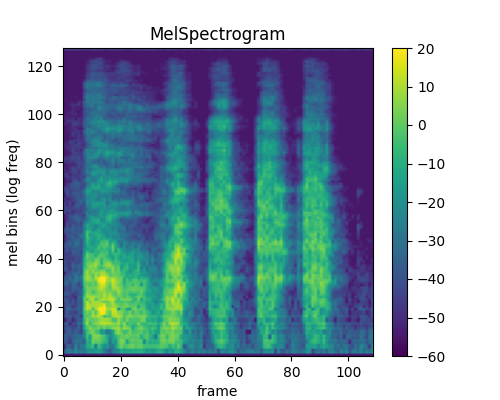

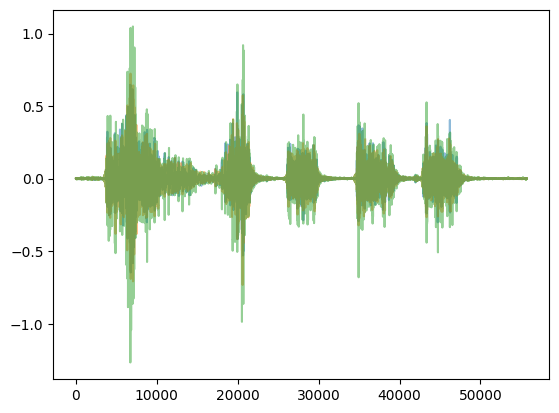

In [ ]:
#| eval: false

# test that
melspecfunc = MelSpectrogramAE(device=device)
melspec, recon3 = melspecfunc.forward(waveform.to(device))
print("melspec.device, melspec.shape, recon3.shape = ",melspec.device, melspec.shape, recon3.shape )
print("melspec.dtype =",melspec.dtype)
recon3 = recon3.to('cpu')
#display(playable_spectrogram(recon3, output_type='live'))
diff = recon3-waveform

#display(playable_spectrogram(diff, specs="waveform", output_type='live')) #plot/play the difference
spec_graph = audio_spectrogram_image(diff, justimage=False, db=False, db_range=[-60,20])
display(spec_graph)
c = 0
for thing in [waveform, recon3, diff]:
    plt.plot(thing[c].cpu().numpy(), alpha=0.5)

# Diffusion models

Wrapper for Zach's DVAE model from September/October. This cannot be subclassed from the above `GivenModel` class if we want to be able to import the checkpoint files. 

In [ ]:
#|export
class DVAEWrapper(GivenModelClass):
    "Wrapper for (hawley's fork of) Zach's DiffusionDVAE"
    def __init__(self, 
        args_dict = {'num_quantizers':0, 'sample_size': 65536, 'demo_steps':50, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0},
        device='cuda',
        debug=True,
        **kwargs,
    ):
        super().__init__()
        class DictObj:
            def __init__(self, in_dict:dict):
                for key, val in in_dict.items():
                    if isinstance(val, (list, tuple)):
                        setattr(self, key, [DictObj(x) if isinstance(x, dict) else x for x in val])
                    else:
                        setattr(self, key, DictObj(val) if isinstance(val, dict) else val)
        self.global_args = DictObj(args_dict)
        self.model = DiffusionDVAE(self.global_args)
        self.device = device
        self.noise = None 
        self.demo_steps = self.global_args.demo_steps
        self.demo_samples = self.global_args.sample_size 
        self.debug = debug
        self.ckpt_info={'ckpt_url':'https://drive.google.com/file/d/1C3NMdQlmOcArGt1KL7pH32KtXVCOfXKr/view?usp=sharing',
                        'ckpt_hash':'6a304c3e89ea3f7ca023f4c9accc5df8de0504595db41961cc7e8b0d07876ef5',
                        'gdrive_path':'MyDrive/AI/checkpoints/DiffusionDVAE.ckpt',
                        'ckpt_path':'/fsx/shawley/checkpoints/dvae_checkpoint.ckpt'}
    
    def encode_it(self, demo_reals):
        module = self.model
        encoder_input = demo_reals
        #print("demo_reals.shape = ",demo_reals.shape)

        if module.pqmf_bands > 1:
            encoder_input = module.pqmf(demo_reals)

        encoder_input = encoder_input.to(self.device)
        demo_reals = demo_reals.to(self.device)
        noise = torch.randn([demo_reals.shape[0], 2, self.demo_samples]).to(self.device)

        with torch.no_grad():
            embeddings = module.encoder_ema(encoder_input)
            if module.quantized:
                if debug: print("Hey, did you know you're quantized? ")
                #Rearrange for Memcodes
                embeddings = rearrange(embeddings, 'b d n -> b n d')
                embeddings, _= module.quantizer_ema(embeddings)
                embeddings = rearrange(embeddings, 'b n d -> b d n')
        
        embeddings = torch.tanh(embeddings)
        return embeddings, noise
        
    def encode(self, waveform: torch.Tensor) -> torch.Tensor:
        self.orig_shape = waveform.shape
        self.demo_samples = waveform.shape[-1]
        reps, self.noise = self.model.encode_it(waveform)
        return reps

    def decode(self, reps: torch.Tensor, demo_steps=None) -> torch.Tensor:
        #print("reps.shape, self.noise.shape = ",reps.shape, self.noise.shape)
        if demo_steps is None: demo_steps=self.demo_steps
        fake_batches = sample(self.model.diffusion_ema, self.noise, demo_steps, 0, reps)
        recon = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
        return recon
    
    def setup(self, device='cuda'):
        ckpt_file = self.ckpt_info['ckpt_path']
        print(f"DVAE: attempting to load checkpoint {ckpt_file}")
        self.get_checkpoint()
        try:
            self.model = self.model.load_from_checkpoint(ckpt_file, global_args=self.global_args)
        except Exception as e:
            print(f"Sorry, exception = {e}. Going with random weights")
        self.model.encode_it = self.encode_it
        self.model.quantized = self.global_args.num_quantizers > 0 
        self.model.eval() # disable randomness, dropout, etc...
        self.model.to(self.device)
        freeze(self.model)  # freeze the weights for inference

## Test our autoencoder options
First prepare a waveform and instantiate the various models

In [ ]:
#| eval: false
print("waveform.shape =      ",waveform.shape)

waveform_pad = given_model.zero_pad_po2(waveform)
print("waveform_pad.shape =  ",waveform_pad.shape)

# optional: to batch or not to batch?
waveform_batch = waveform_pad.unsqueeze(0)
print(f"waveform_batch.shape = {waveform_batch.shape}, dtype = {waveform.dtype}")

given_models = [SpectrogramAE(), MagSpectrogramAE(), MelSpectrogramAE(), DVAEWrapper()]
_ = [x.setup() for x in given_models]

waveform.shape =       torch.Size([2, 55728])
waveform_pad.shape =   torch.Size([2, 65536])
waveform_batch.shape = torch.Size([1, 2, 65536]), dtype = torch.float32
DVAE: attempting to load checkpoint /fsx/shawley/checkpoints/dvae_checkpoint.ckpt
Checkpoint found!


Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../checkpoints/dvae_checkpoint.ckpt`


Now run the waveform through the models:

given_model.name =  SpectrogramAE
For model SpectrogramAE, reps.shape = torch.Size([1, 2, 513, 257]) and dtype = torch.complex64. recon.shape = torch.Size([2, 65536])


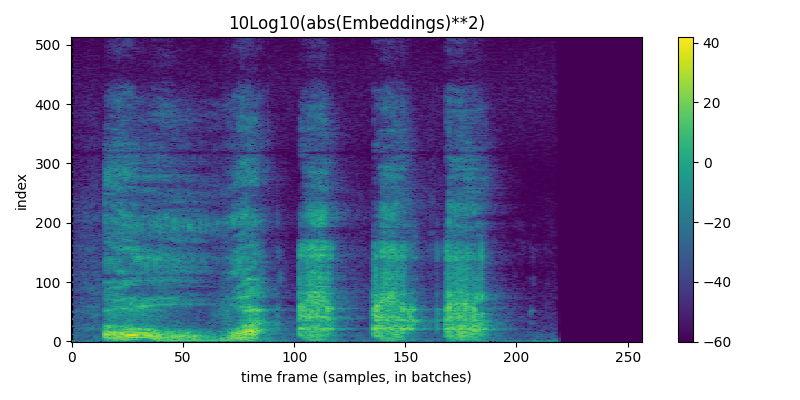

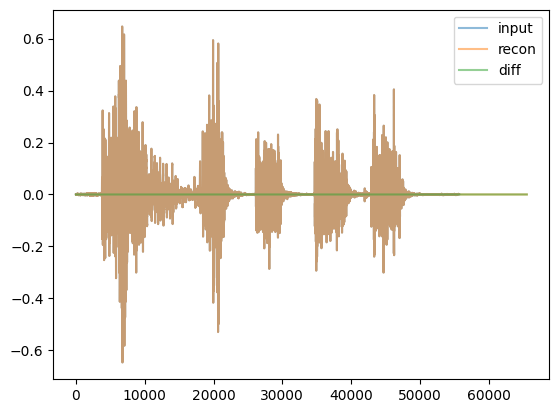

given_model.name =  MagSpectrogramAE
For model MagSpectrogramAE, reps.shape = torch.Size([1, 2, 513, 257]) and dtype = torch.float32. recon.shape = torch.Size([2, 65536])


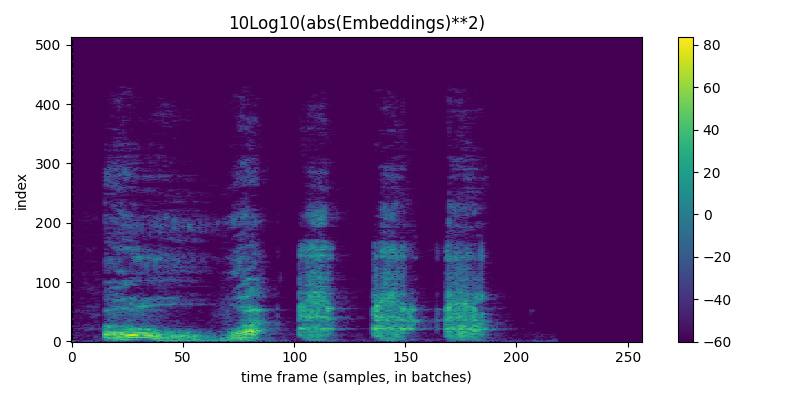

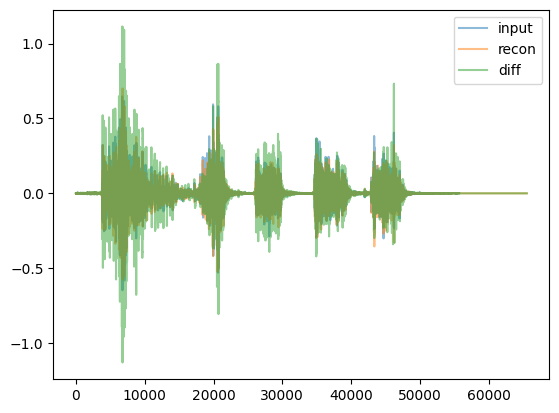

given_model.name =  MelSpectrogramAE
For model MelSpectrogramAE, reps.shape = torch.Size([1, 2, 128, 257]) and dtype = torch.float32. recon.shape = torch.Size([2, 65536])


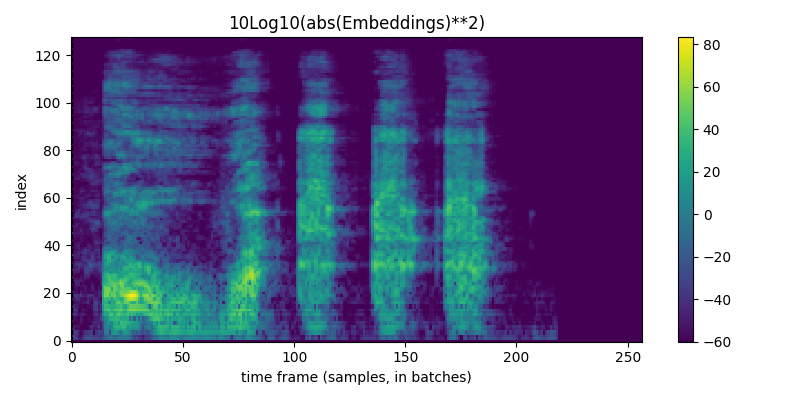

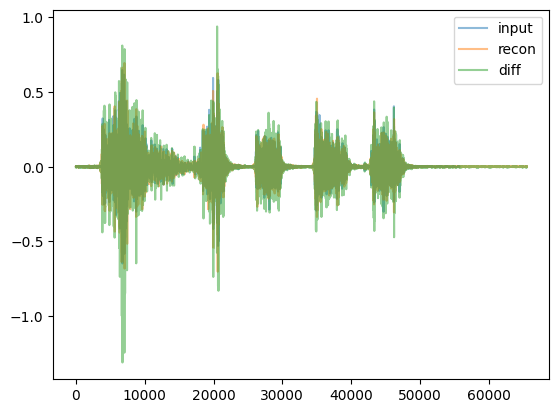

given_model.name =  DVAEWrapper


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


For model DVAEWrapper, reps.shape = torch.Size([1, 1, 64, 512]) and dtype = torch.float32. recon.shape = torch.Size([2, 65536])


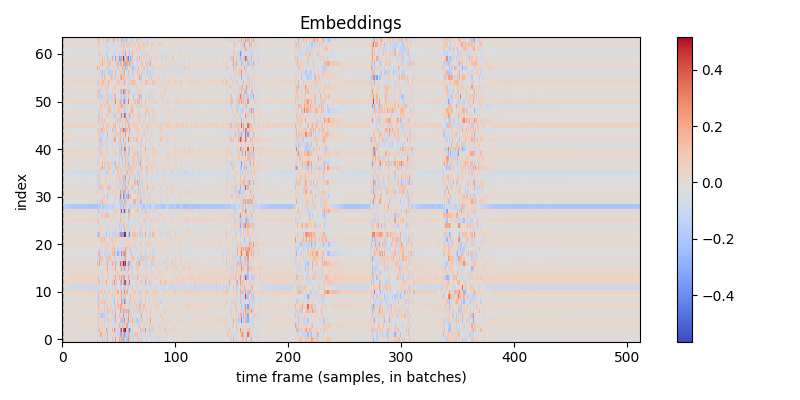

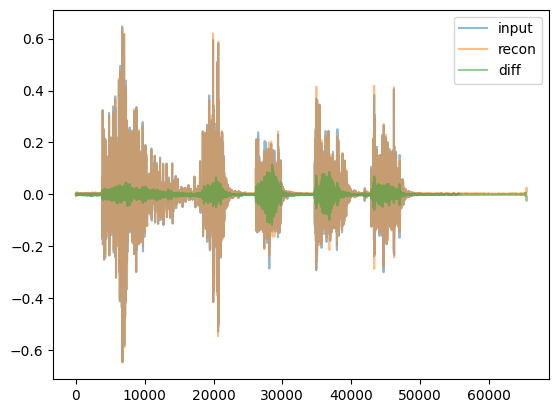

In [ ]:
#| eval: false
#print("original audio:")
#display(playable_spectrogram(waveform.cpu(), specs="waveform", output_type='live'))

for given_model in given_models:
    print("given_model.name = ",given_model.name)
    given_model = given_model.to(device)
    reps = given_model.encode(waveform_batch.to(device))
    recon = given_model.decode(reps) 
    recon = recon.squeeze()
    if len(reps.shape) < 4: reps = reps.unsqueeze(0)
    print(f"For model {given_model.name}, reps.shape = {reps.shape} and dtype = {reps.dtype}. recon.shape = {recon.shape}")
    if given_model.name == 'DVAEWrapper':
        title, cmap = 'Embeddings', 'coolwarm'
        vals = reps[:,0,:,:]
    else:
        title, cmap ='10Log10(abs(Embeddings)**2)', 'viridis'
        vals = 10*torch.log10(torch.abs(reps[:,0,:,:])**2+1e-6)

    display(tokens_spectrogram_image(vals.cpu(), title=title, mark_batches=True, symmetric=False, cmap=cmap))
    #display(playable_spectrogram(recon.cpu(), specs="all", output_type='live'))
    diff = waveform_pad - recon.cpu()
    for thing,name in zip([waveform, recon.cpu(), diff], ['input','recon','diff']):
        plt.plot(thing[0,:].numpy(), alpha=0.5, label=name) # just left channel for now
    plt.legend()
    plt.show()

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()